In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data
import rff
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression

In [2]:
class Args(object):
    def __init__(self, n_fp_rff, n_bit, 
                 exact_kernel, reg_lambda, 
                 sigma, random_seed, data_path,
                 do_fp, test_var_reduce=False):
        self.n_fp_rff = n_fp_rff
        self.n_bit = n_bit
        self.exact_kernel = exact_kernel
        self.reg_lambda = reg_lambda
        self.sigma = sigma
        self.random_seed = random_seed
        self.data_path = data_path
        self.do_fp = do_fp
        self.test_var_reduce = test_var_reduce

In [3]:
def load_census_data(path):
    X_test = np.load(path + "X_ho.npy")
    X_train = np.load(path + "X_tr.npy")
    Y_test = np.load(path + "Y_ho.npy")
    Y_train = np.load(path + "Y_tr.npy")
    X_test = X_test.item()['X_ho']
    X_train = X_train.item()['X_tr']
    Y_test = Y_test.item()['Y_ho']
    Y_train = Y_train.item()['Y_tr']
#     s = np.arange(X_train.shape[0] )
#     np.random.shuffle(s)
#     X_train = X_train[s, :]
#     Y_train = Y_train[s]
#     X_train, Y_train, X_test, Y_test = \
#       X_train[:(s.size * 2 / 3), :], Y_train[:(s.size * 2 / 3)], X_test[:(s.size * 2 / 3), :], Y_test[:(s.size * 2 / 3)]
    return X_train, X_test, Y_train, Y_test

In [4]:
data_path = "../../../data/census/"

In [5]:
def get_spectrum(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    train_error = regressor.get_train_error()
    pred = regressor.predict(X_test, quantizer_train=quantizer_train, quantizer_test=quantizer_test)
    test_error = regressor.get_test_error(Y_test)
    print("check l2 error test error and train error ", test_error, train_error)

    # get kernel approximation error 
    kernel_mat_approx_error_train = torch.sum( (regressor.kernel_mat - kernel_mat_exact_train)**2)
    kernel_mat_approx_error_test = torch.sum( (regressor.kernel_mat_pred - kernel_mat_exact_test)**2)
    print("check kernel error test error and train error ", kernel_mat_approx_error_train, kernel_mat_approx_error_test)
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s, kernel_mat.cpu().numpy()

### generate plot for spectrum comparison under the same # of rff (note accidentally without naming using full_dataset)

In [6]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_exact, k_exact = get_spectrum(args)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset_for_table.npy", "wb") as f:
#     np.save(f, s_exact)
with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, k_exact)
# print s_exact

('using sigma ', 30.0)
('using sigma ', 30.0)
exact kernel
start to do regression!
('using sigma ', 30.0)
('using regularior strength ', 0.001)
finish regression!
('using sigma ', 30.0)
('check l2 error test error and train error ', 28635565.746743534, 5882639.16675007)
('check kernel error test error and train error ', 0.0, 0.0)


In [ ]:
for seed in range(1, 11):
    args = Args(n_fp_rff=8192, n_bit=8, 
                exact_kernel=False, reg_lambda=1e-3, 
                sigma=30.0, random_seed=seed, 
                data_path=data_path, do_fp=True)
    s_fp, k_fp = get_spectrum(args)
    with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, s_fp)
    with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, k_fp)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('using regularior strength ', 0.001)
finish regression!
('check l2 error test error and train error ', 32688571.329237305, 7056476.9794684835)
('check kernel error test error and train error ', 9805.65579266715, 1083.3929885185432)
('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 2)
('using n rff features ', 8192)
start to do regression!
('using regularior strength ', 0.001)
finish regression!
('check l2 error test error and train error ', 32095403.983813383, 7017679.03853014)
('check kernel error test error and train error ', 7819.318579547259, 864.0171263206198)
('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 3)
('using n rff features ', 8192)
start to do re

In [37]:
np.mean([32688571.329237305, 32095403.983813383, 32502258.37912666, 32240285.600661334, 33567202.81019511, 30625580.688810337, 31647992.594026696, 33811228.0429921, 28622646.181034874, 29463281.393114615])

31726445.100301243

In [ ]:
for seed in range(1, 11):
    args = Args(n_fp_rff=4096, n_bit=8, 
                exact_kernel=False, reg_lambda=1e-2, 
                sigma=30.0, random_seed=seed, 
                data_path=data_path, do_fp=True)
    s_fp, k_fp = get_spectrum(args)
    with open("../multi_seed_results/spectrum/s_4096_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, s_fp)
    with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, k_fp)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 4096)
start to do regression!
('using regularior strength ', 0.01)
finish regression!
('check l2 error test error and train error ', 33447429.2053789, 14033135.55027548)
('check kernel error test error and train error ', 67324.61461904043, 7482.2096459274435)
('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 2)
('using n rff features ', 4096)
start to do regression!
('using regularior strength ', 0.01)
finish regression!
('check l2 error test error and train error ', 33450589.557279676, 13999328.610658262)
('check kernel error test error and train error ', 40607.982314463916, 4446.91302487432)
('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 3)
('using n rff features ', 4096)
start to do regr

In [38]:
np.mean([33447429.2053789, 33450589.557279676, 35442117.43300067, 35964219.77480749, 33972917.14661751, 33928471.81367612, 34102339.98639893, 36035166.40980735, 33691455.92197279, 31638197.299065333])

34167290.454800479

In [ ]:
for seed in range(1, 11):
    args = Args(n_fp_rff=4096, n_bit=1, 
                exact_kernel=False, reg_lambda=1e-1, 
                sigma=30.0, random_seed=seed, 
                data_path=data_path, do_fp=False)
    s_1, k_1 = get_spectrum(args)
    with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, s_1)
    with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset_seed" + str(seed) + ".npy", "wb") as f:
        np.save(f, k_1)
    
    

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 1)
('using regularior strength ', 0.1)
finish regression!
('quantization 1 activated ', (1819, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 1)
('check l2 error test error and train error ', 84141226.64312068, 728973.0170243734)
('check kernel error test error and train error ', 22528.940600154267, 1556.3498428840976)
('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff w

('using regularior strength ', 0.1)
finish regression!
('quantization 1 activated ', (1819, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantizer using random seed', 9)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 9)
('check l2 error test error and train error ', 80456329.35616308, 727561.6455286815)
('check kernel error test error and train error ', 23227.78376953194, 1647.7032035368818)
('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 10)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantizer using random seed', 10)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 10)
('using regularior strength

In [39]:
np.mean([84141226.64312068, 81835066.49970563, 81253209.57972126, 82833226.60445268, 81746745.10933767, 83769335.9704879, 84811858.8482857, 80383134.85633498, 80456329.35616308, 82161376.56667696])

82339151.003428668

In [9]:
# with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset_seed5.npy", "rb") as f:
#     k_1 = np.load(f)
# with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_full_dataset_seed5.npy", "rb") as f:
#     k_fp_upper = np.load(f)
# with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_full_dataset_seed5.npy", "rb") as f:
#     k_fp_lower = np.load(f)
# with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "rb") as f:
#     k_exact = np.load(f)

In [35]:
k_1 = []
k_fp_upper = []
k_fp_lower = []
k_exact = []
with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "rb") as f:
    k_exact = np.load(f)
for seed in range(1, 11):
    with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        k_1.append(np.load(f) - k_exact)
    with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        k_fp_upper.append(np.load(f) - k_exact)
    with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        k_fp_lower.append(np.load(f) - k_exact)
k_1 = np.hstack(k_1)
k_fp_upper = np.hstack(k_fp_upper)
k_fp_lower = np.hstack(k_fp_lower)
print np.sum(k_1**2)/10.0, np.sum(k_fp_upper**2)/10.0, np.sum(k_fp_lower**2)/10.0
print np.sqrt(np.sum(k_1**2)/10.0/np.sum(k_exact**2) ) , \
    np.sqrt(np.sum(k_fp_upper**2)/10.0/np.sum(k_exact**2) ), \
    np.sqrt(np.sum(k_fp_lower**2)/10.0/np.sum(k_exact**2) )

23083.8162635 32694.2235999 16212.1217801
0.0103845975395 0.0123586598635 0.00870273569658


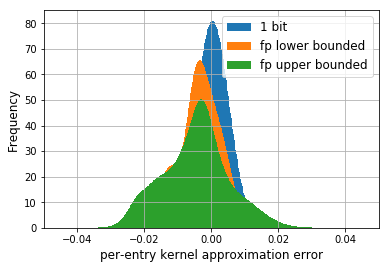

In [36]:
plt.figure()

# print "shrink done"
# # bins = np.arange(-10, 10, 1000)
# hist1, bin_edge1 = np.histogram(k_1 - k_exact, bins=1000, density=True)
# print "hist done"
# hist2, bin_edge2 = np.histogram(k_fp_upper - k_exact, bins=1000, density=True)
# hist3, bin_edge3 = np.histogram(k_fp_lower - k_exact, bins=1000, density=True)
# print "hist all done"
# plt.bar(bin_edge1[:-1], hist1, label="1 bit")
# print "plot done"

# plt.bar(bin_edge2[:-1], hist2, label="fp upper bounded")
# plt.bar(bin_edge3[:-1], hist3, label="fp lower bounded")

# _ = np.histogram((k_1 - k_exact).ravel()[::3000], density=True)
weights = np.ones_like(k_1.ravel() ) / float(k_1.size)
_ = plt.hist(k_1.ravel(), bins=5000, normed=True, label="1 bit")
_ = plt.hist(k_fp_lower.ravel(), bins=1000, normed=True, label="fp lower bounded")
_ = plt.hist(k_fp_upper.ravel(), bins=1000, normed=True, label="fp upper bounded")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.plot(s_exact, label="exact")
plt.grid()
plt.xlim([-0.05, 0.05])
plt.legend(framealpha=0.8, fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("per-entry kernel approximation error", fontsize=12)
plt.savefig("./error_histogram.pdf")
plt.show()

In [15]:
k_1 = None
k_fp_upper = None
k_fp_lower = None
k_exact = None
for seed in range(1, 11):
    with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_1 is None:
            k_1 = np.load(f)
        else:
            k_1 += np.load(f)
    with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_fp_upper is None:
            k_fp_upper = np.load(f)
        else:
            k_fp_upper += np.load(f)
    with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_fp_lower is None:
            k_fp_lower = np.load(f)
        else:
            k_fp_lower += np.load(f)
k_1 /= 10.0
k_fp_upper /= 10.0
k_fp_lower /= 10.0
with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "rb") as f:
    k_exact = np.load(f)

In [16]:
with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_4096_feat_fp_64b_svd_full_dataset.npy", "rb") as f:
    s_fp_upper = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_full_dataset.npy", "rb") as f:
    s_fp_lower = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

In [17]:
print k_1.shape
print k_exact.shape
print k_fp_upper.shape
print k_fp_lower.shape

(16367, 16367)
(16367, 16367)
(16367, 16367)
(16367, 16367)


In [18]:
# print np.max(k_1 - k_exact), np.min(k_1 - k_exact), np.mean(k_1 - k_exact)
# print np.max(k_fp_upper - k_exact), np.min(k_fp_upper - k_exact), np.mean(k_fp_upper - k_exact)
# print np.max(k_fp_lower - k_exact), np.min(k_fp_lower - k_exact), np.mean(k_fp_lower - k_exact)
# print hist1, bin_edge1

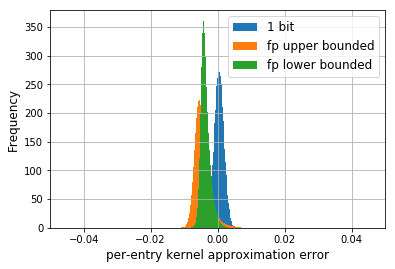

In [20]:
plt.figure()
# value = k_1 - k_exact
# k_1_small = k_1.ravel()[::10000]
# k_exact_small = k_exact.ravel()[::10000]
# k_fp_upper_small = k_fp_upper.ravel()[::10000]
# k_fp_lower_small = k_fp_lower.ravel()[::10000]
# k_1_small = k_1
# k_exact_small = k_exact[:1000000000]
# k_fp_upper_small = k_fp_upper[:1000000000]
# k_fp_lower_small = k_fp_lower[:1000000000]

# print "shrink done"
# # bins = np.arange(-10, 10, 1000)
# hist1, bin_edge1 = np.histogram(k_1 - k_exact, bins=1000, density=True)
# print "hist done"
# hist2, bin_edge2 = np.histogram(k_fp_upper - k_exact, bins=1000, density=True)
# hist3, bin_edge3 = np.histogram(k_fp_lower - k_exact, bins=1000, density=True)
# print "hist all done"
# plt.bar(bin_edge1[:-1], hist1, label="1 bit")
# print "plot done"

# plt.bar(bin_edge2[:-1], hist2, label="fp upper bounded")
# plt.bar(bin_edge3[:-1], hist3, label="fp lower bounded")

# _ = np.histogram((k_1 - k_exact).ravel()[::3000], density=True)
_ = plt.hist( (k_1 - k_exact).ravel(), bins=5000, density=True, label="1 bit")
_ = plt.hist( (k_fp_upper - k_exact).ravel(), bins=1000, density=True, label="fp upper bounded")
_ = plt.hist( (k_fp_lower - k_exact).ravel(), bins=1000, density=True, label="fp lower bounded")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.plot(s_exact, label="exact")
plt.grid()
plt.xlim([-0.05, 0.05])
plt.legend(framealpha=0.8, fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("per-entry kernel approximation error", fontsize=12)
plt.savefig("./error_histogram.pdf")
plt.show()

In [22]:
k_1 = None
k_fp_upper = None
k_fp_lower = None
k_exact = None
for seed in range(5, 6):
    with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_1 is None:
            k_1 = np.load(f)
        else:
            k_1 += np.load(f)
    with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_fp_upper is None:
            k_fp_upper = np.load(f)
        else:
            k_fp_upper += np.load(f)
    with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_full_dataset_seed" + str(seed) + ".npy", "rb") as f:
        if k_fp_lower is None:
            k_fp_lower = np.load(f)
        else:
            k_fp_lower += np.load(f)
k_1 /= 1.0
k_fp_upper /= 1.0
k_fp_lower /= 1.0
with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "rb") as f:
    k_exact = np.load(f)

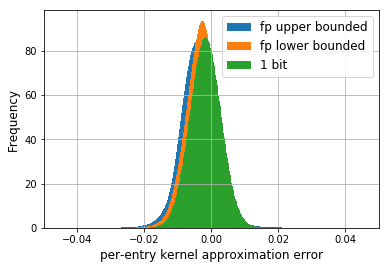

In [24]:
plt.figure()
# value = k_1 - k_exact
# k_1_small = k_1.ravel()[::10000]
# k_exact_small = k_exact.ravel()[::10000]
# k_fp_upper_small = k_fp_upper.ravel()[::10000]
# k_fp_lower_small = k_fp_lower.ravel()[::10000]
# k_1_small = k_1
# k_exact_small = k_exact[:1000000000]
# k_fp_upper_small = k_fp_upper[:1000000000]
# k_fp_lower_small = k_fp_lower[:1000000000]

# print "shrink done"
# # bins = np.arange(-10, 10, 1000)
# hist1, bin_edge1 = np.histogram(k_1 - k_exact, bins=1000, density=True)
# print "hist done"
# hist2, bin_edge2 = np.histogram(k_fp_upper - k_exact, bins=1000, density=True)
# hist3, bin_edge3 = np.histogram(k_fp_lower - k_exact, bins=1000, density=True)
# print "hist all done"
# plt.bar(bin_edge1[:-1], hist1, label="1 bit")
# print "plot done"

# plt.bar(bin_edge2[:-1], hist2, label="fp upper bounded")
# plt.bar(bin_edge3[:-1], hist3, label="fp lower bounded")

# _ = np.histogram((k_1 - k_exact).ravel()[::3000], density=True)
# _ = plt.hist( (k_1 - k_exact).ravel(), bins=5000, density=True, label="1 bit")
_ = plt.hist( (k_fp_upper - k_exact).ravel(), bins=1000, density=True, label="fp upper bounded")
_ = plt.hist( (k_fp_lower - k_exact).ravel(), bins=1000, density=True, label="fp lower bounded")
_ = plt.hist( (k_1 - k_exact).ravel(), bins=5000, density=True, label="1 bit")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.plot(s_exact, label="exact")
plt.grid()
plt.xlim([-0.05, 0.05])
plt.legend(framealpha=0.8, fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("per-entry kernel approximation error", fontsize=12)
plt.savefig("./error_histogram_seed5.pdf")
plt.show()

In [8]:
args = Args(n_fp_rff=4096, n_bit=16, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_16 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_16_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_16)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  16
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 16)
('quantizer 1 scale', 4.7684443427176318e-07)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 16)
('quantizer 2 scale', 4.7684443427176318e-07)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [9]:
args = Args(n_fp_rff=2048, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_8 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_8_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_8)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  8
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 8)
('quantizer 1 scale', 0.00012254901960784314)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 8)
('quantizer 2 scale', 0.00012254901960784314)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [10]:
args = Args(n_fp_rff=1024, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_4 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_4)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [11]:
args = Args(n_fp_rff=512, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_2 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_512_feat_2_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_2)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.010416666666666666)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.010416666666666666)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [12]:
args = Args(n_fp_rff=256, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_256_feat_1_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_1)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.03125)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.03125)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


### exact kernel

In [11]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_exact = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_exact)
# print s_exact

('using sigma ', 30.0)
('using sigma ', 30.0)
exact kernel
start to do regression!
('using sigma ', 30.0)
('using regularior strength ', 0.001)
finish regression!


### 1024 feature full precision

In [12]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=True)
s_fp = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "wb") as f:
    np.save(f, s_fp)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
    test = np.load(f)
print np.sum(s_fp - test)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('using regularior strength ', 0.001)
finish regression!
0.0


### 1024 feature 8 --> 1 bit

In [8]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_8 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_8)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  8
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 4096)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 8)
('quantizer 1 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 8)
('quantizer 2 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [7]:
args = Args(n_fp_rff=1024, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_4 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_4)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [6]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_2 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_2)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [25]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (10911, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.015625)
('quantizer using random seed', 1)


KeyboardInterrupt: 

In [7]:
args = Args(n_fp_rff=1024, n_bit=16, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_16 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_16)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  16
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 2048)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 16)
('quantizer 1 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 16)
('quantizer 2 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [8]:
args = Args(n_fp_rff=1024, n_bit=32, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_32 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_32)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  32
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 32)
('quantizer 1 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 32)
('quantizer 2 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [6]:
args = Args(n_fp_rff=2048, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0014731391274719742)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0014731391274719742)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [7]:
args = Args(n_fp_rff=2048, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.005208333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.005208333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [8]:
args = Args(n_fp_rff=2048, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.011048543456039806)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.011048543456039806)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [9]:
args = Args(n_fp_rff=4096, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0010416666666666667)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0010416666666666667)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [10]:
args = Args(n_fp_rff=4096, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0036828478186799354)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0036828478186799354)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [11]:
args = Args(n_fp_rff=4096, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [17]:
args = Args(n_fp_rff=8192, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.00073656956373598711)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.00073656956373598711)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [18]:
args = Args(n_fp_rff=8192, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0026041666666666665)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0026041666666666665)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [19]:
args = Args(n_fp_rff=8192, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 262144)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0055242717280199029)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0055242717280199029)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [4]:
# with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
#     s_4_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
#     s_2_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd.npy", "rb") as f:
#     s_exact_small = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

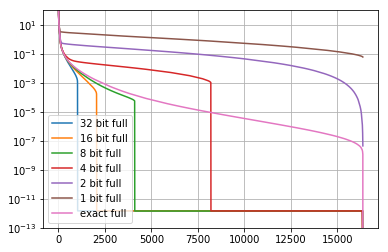

In [5]:
plt.figure()
plt.semilogy(s_32, label="32 bit full")
plt.semilogy(s_16, label="16 bit full")
plt.semilogy(s_8, label="8 bit full")
plt.semilogy(s_4, label="4 bit full")
plt.semilogy(s_2, label="2 bit full")
plt.semilogy(s_1, label="1 bit full")
plt.semilogy(s_exact, label="exact full")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact_small, label="exact partial")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

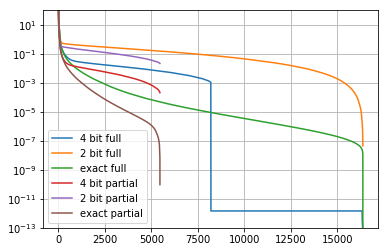

In [14]:
plt.figure()
# plt.semilogy(s_exact, label="exact")
# plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit full")
plt.semilogy(s_2, label="2 bit full")
plt.semilogy(s_exact, label="exact full")
plt.semilogy(s_4_small, label="4 bit partial")
plt.semilogy(s_2_small, label="2 bit partial")
plt.semilogy(s_exact_small, label="exact partial")
# plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### plot full spectrum

In [3]:
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact.npy", "rb") as f:
    s_exact = np.load(f)

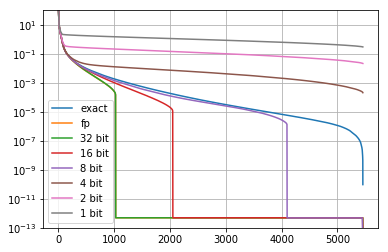

In [4]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32, label="32 bit")
plt.semilogy(s_16, label="16 bit")
plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

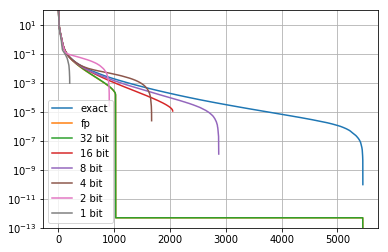

In [5]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

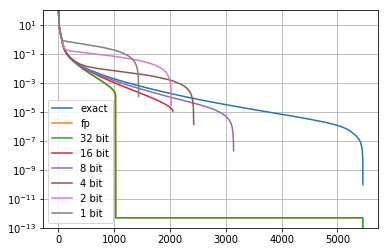

In [6]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 / 3.0 * 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 / 3.0 * 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 / 3.0 * 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 / 3.0 * 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 / 3.0 * 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 / 3.0 * 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### exploration on spectrum

In [37]:
def get_spectrum_test(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    print "test rff1 ", regressor.kernel.rff_x1
    print "test rff2 ", regressor.kernel.rff_x2
    
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s, kernel_mat.cpu().numpy().astype(np.float64)

In [38]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!


KeyboardInterrupt: 

[ 2.  2.  2. ...,  2.  2.  2.]
[[ 2.          0.92578125  0.8515625  ...,  0.84863281  0.84277344
   0.91308594]
 [ 0.92578125  2.          0.94335938 ...,  0.88378906  0.87011719
   0.93457031]
 [ 0.8515625   0.94335938  2.         ...,  0.86230469  0.87597656
   0.91894531]]


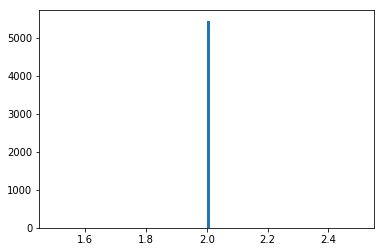

In [39]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

In [42]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!
test rff1  
1.00000e-02 *
-1.1049  0.3683  0.3683  ...  -0.3683  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  0.3683
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  1.1049
          ...             ⋱             ...          
-1.1049 -0.3683  1.1049  ...  -1.1049  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  1.1049
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  0.3683
[torch.DoubleTensor of size 5456x16384]

test rff

[ 1.09895833  1.12087674  1.12717014 ...,  1.1265191   1.12836372
  1.12250434]
[[ 1.09895833  0.84337023  0.8390842  ...,  0.85161675  0.7464464
   0.83037652]
 [ 0.84337023  1.12087674  0.95876736 ...,  0.94986979  0.92938911
   0.91414388]
 [ 0.8390842   0.95876736  1.12717014 ...,  0.9570855   0.90725369
   0.9121365 ]]


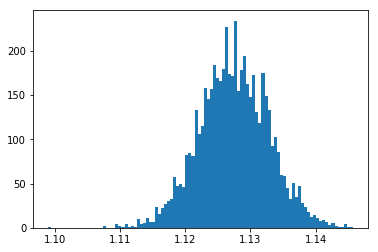

In [43]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

[  4.87422412e+03   9.92007523e+01   7.62955627e+01 ...,   6.18245899e-09
   4.54027393e-09   9.55269891e-11]


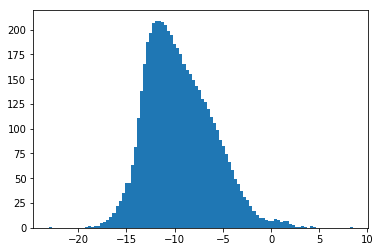

In [6]:
print s_exact
plt.figure()
_ = plt.hist(np.log(s_exact),bins=100)
plt.show()

[  4.91588923e+03   9.76161314e+01   7.45011299e+01 ...,   4.80692726e-13
   1.01362488e-13   4.13374761e-14]


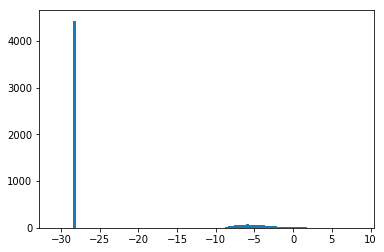

In [7]:
print s_fp
plt.figure()
_ = plt.hist(np.log(s_fp),bins=100)
plt.show()

[  4.91645370e+03   9.36678968e+01   7.49424546e+01 ...,   4.90781849e-13
   1.30537380e-13   3.44960307e-14]


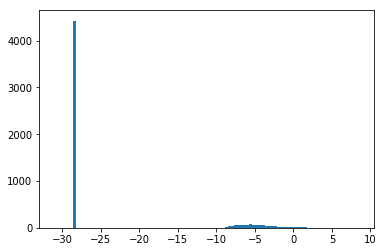

In [8]:
print s_32
plt.figure()
_ = plt.hist(np.log(s_32),bins=100)
plt.show()

[  4.92772646e+03   9.92845382e+01   7.16227742e+01 ...,   1.30972131e-13
   5.50731281e-14   5.32621153e-14]


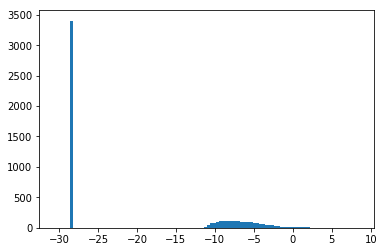

In [9]:
print s_16
plt.figure()
_ = plt.hist(np.log(s_16),bins=100)
plt.show()

[  4.79986673e+03   1.01274638e+02   8.09237702e+01 ...,   2.91166374e-14
   2.01892143e-14   6.35161380e-15]


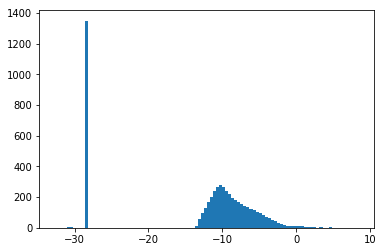

In [10]:
print s_8
plt.figure()
_ = plt.hist(np.log(s_8),bins=100)
plt.show()

[  4.85706958e+03   1.03042343e+02   7.59865365e+01 ...,   2.20834156e-04
   2.13297390e-04   2.10150551e-04]


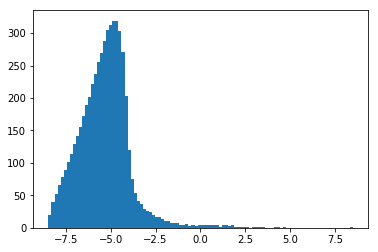

In [11]:
print s_4
plt.figure()
_ = plt.hist(np.log(s_4),bins=100)
plt.show()

[  4.87785233e+03   1.00451189e+02   8.06809640e+01 ...,   2.18074883e-02
   2.16997374e-02   2.16595938e-02]


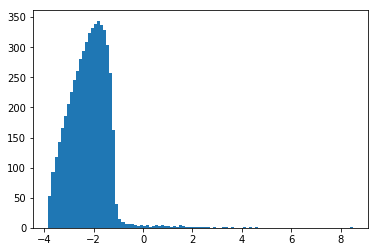

In [12]:
print s_2
plt.figure()
_ = plt.hist(np.log(s_2),bins=100)
plt.show()

[  4.87050873e+03   9.96647985e+01   8.00128565e+01 ...,   3.02800135e-01
   3.01387460e-01   3.00918557e-01]


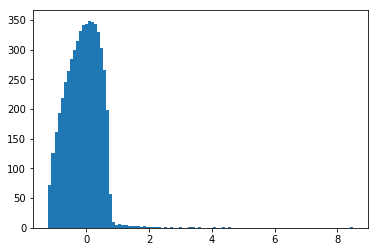

In [13]:
print s_1
plt.figure()
_ = plt.hist(np.log(s_1),bins=100)
plt.show()

# Below are old cold

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  7.01975496e-03,   1.65006816e+00,   3.29311657e+00,
          4.93616497e+00,   6.57921338e+00,   8.22226178e+00,
          9.86531019e+00,   1.15083586e+01,   1.31514070e+01,
          1.47944554e+01,   1.64375038e+01]),
 <a list of 10 Patch objects>)

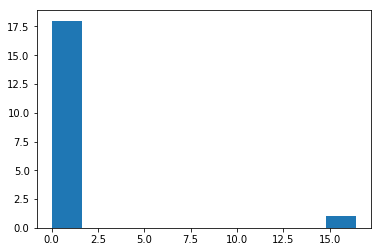

In [56]:
plt.hist(s)